<a href="https://www.kaggle.com/code/brunosantanna/iban-validator-model?scriptVersionId=106417589" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# IBAN Validator Model

This is a machine learning model for validating [IBAN](https://www.iso13616.org)
account numbers.

Source code is available at [bsantanna/iban-validator-model](https://github.com/bsantanna/iban-validator-model) Github repository.

# Project description

Main motivation for creating this project was study and self development in the subjects
of [Deep Learning](https://en.wikipedia.org/wiki/Deep_learning)
and [Artificial Neural Networks](https://en.wikipedia.org/wiki/Artificial_neural_network)
using [Tensorflow](https://www.tensorflow.org), a popular Machine Learning Platform.

Considering the Artificial Intelligence domain landscape in the year of 2022, several Machine Learning SaaS and PaaS
offers available in the market in a field of computer science that just had become a mainstream topic. It just made
sense to me picking one major framework and start practicing with a well known problem such as IBAN validation.

As a software engineer, with this project I had found answers to some of my practical questions and was rewarded with
proficiency in modeling neural networks and distributing them for prediction at scale using cloud containers.

# The challenge

Looking for an idea for a hands-on/short-lived project to practice and learn Neural Network modelling
with [Keras](https://keras.io/api/) and [TensorFlow](https://www.tensorflow.org/), I came across this idea of creating
this [IBAN](https://www.iso13616.org) validator as this is a simple use case with good references over the internet.

# The proposed solution

In order to employ a simple yet efficient Machine Learning Model, the proposed solution
addresses the challenge using the following approach.

> 1. The Machine Learning Model should memorize [tabular data](https://github.com/bsantanna/iban-validator-model/blob/main/modules/training/data/country_validation_json.csv)) with country
     specific [Regular Expression](https://en.wikipedia.org/wiki/Regular_expression) rules formatted as static JSON
     document strings.
> 2. Predict the correct JSON when other items from the table are given as features, extracted from the
     input [IBAN](https://www.iso13616.org); 2-letter [ISO 3166-1](https://en.wikipedia.org/wiki/ISO_3166-1) country
     code and length / size.
> 3. Use language specific regular expression to parse predicted JSON and validate the
     input [IBAN](https://www.iso13616.org)

# Dependencies

Model dependencies:

- [Jupyter](https://jupyter.org): Used as interactive development environment.
- [Matplotlib](https://matplotlib.org): Used for plotting error loss function result over epochs to measure training
  results.
- [Pandas](https://pandas.pydata.org/pandas-docs/stable/): Used as main tabular data manipulation framework.
- [TensorFlow](https://www.tensorflow.org/api_docs/python/tf): Used as Machine Learning Platform and one of the main
  topics of interest of this project.
- [Keras](https://keras.io/api/): Used as Deep Learning and Neural Network fluent design API and another of the main
  topics of interest of this project.
  
---

# Model Training

The model training starts by making dependencies available to Python interpreter.

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
import tensorflow as tf

# Globals
 
 - A batch size of 32 lead to good results.
 - A batch size of 16 also lead to good results with faster training however model precision decreased.
 - 500 epochs seem a good number for iteration.
 - The curve of error loss further in this notebook indicates about 300 epochs would be enough.


In [2]:
# Globals
batch_size = 32
num_epochs = 500

# Utility Function: Pandas Dataframe to Tensorflow Dataset

  - This utility function is used to convert a Pandas Dataframe object instance to a Tensorflow [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object instance.
  - As per official documentation states, a Dataset object in Tensorflow API is a memory efficient accessor to a potentially large set of elements. 
  - A Dataset is used in this model to format input features and target labels.
  - The target label is encoded in a one-hot encoded version using [tf.keras.utils.to_categorical ](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) and this way it can be used to return a vector of floating points as prediction.

In [3]:
def dataframe_to_dataset(dataframe):
    # extract features and labels from input dataframe
    features = dataframe.drop(["JSON"], axis=1)
    labels = tf.keras.utils.to_categorical(dataframe["JSON"].factorize()[0])
    
    # initialize dataset using from_tensor_slices factory method
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    ds = ds.shuffle(buffer_size=len(features))
    
    return ds

# Utility Function: Encode categorical feature

  - This utility function can be used to encode multiple types of categorical features such as strings.
  - In this model the function serves to encode the *Code* column / field, which corresponds to 2-letter [ISO 3166-1](https://en.wikipedia.org/wiki/ISO_3166-1) country
     code and returns a [tf.keras.layers.StringLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) layer for input encoding

In [4]:
def encode_categorical_feature(feature, name, dataset, is_string=False, use_lookup=True, max_tokens=0):
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    if use_lookup:
        encoding_layer_class = tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
        encoding_layer = encoding_layer_class(output_mode="binary")
        encoding_layer.adapt(feature_ds)

    elif is_string:
        encoding_layer = tf.keras.layers.TextVectorization()
        encoding_layer.adapt(feature_ds)

    else:
        encoding_layer = tf.keras.layers.Hashing(num_bins=max_tokens, output_mode="one_hot")

    encoded_feature = encoding_layer(feature)
    return encoded_feature

# Utility Function: Encode numerical feature

 - This utility function can be used to encode numerical features with [tf.keras.layers.Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization).
 - Normalization improved model results because some numbers are repeated so this created a smaller number of different categories, thats why this was used rather than another category encoder
 - Normalization also reduces the side effects of outliers during model training process.

In [5]:
def encode_numerical_feature(feature, name, dataset):
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)

    return encoded_feature

# Utility Function: Build model

 - This function is used to build the model.
 - Two input features are encoded and merged again into a single layer named *features*
   - Code: 2-letter [ISO 3166-1](https://en.wikipedia.org/wiki/ISO_3166-1) country
     code
   - Size: IBAN length.
 - Input [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) has the number of neurons matching the batch size defined in the globals, different sizes lead to issues with training shapes. Activation function with better results were *relu* and *selu*
 - Output [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) has the number of neurons mathing the number of categories.
 - [Adam](https://keras.io/api/optimizers/adam/) as optimizer function, Adam is a computation efficient variant of stochastic gradient descend.
 - [Categorical cross entropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) as error loss function. 

In [6]:
def build_model(dataset, num_categories):
    # Categorical feature
    feature_code = tf.keras.Input(shape=(1,), name="Code", dtype="string")
    feature_code_encoded = encode_categorical_feature(feature_code, "Code", dataset, is_string=True)

    # Numerical feature
    feature_size = tf.keras.Input(shape=(1,), name="Size", dtype="int64")
    feature_size_encoded = encode_numerical_feature(feature_size, "Size", dataset)

    # Inputs
    inputs = [
        feature_code,
        feature_size
    ]

    features = tf.keras.layers.concatenate([
        feature_code_encoded,
        feature_size_encoded
    ])

    input_layer = tf.keras.layers.Dense(batch_size, activation="relu")(features)
    output_layer = tf.keras.layers.Dense(num_categories, activation="softmax")(input_layer)

    model = tf.keras.Model(inputs, output_layer)
    model.compile("adam", "categorical_crossentropy", metrics=[
        "accuracy",
    ])

    return model



# Utility Function: Predict JSON

  - This function is used to perform input and output conversions
  - Inputs are converted to tensors using [tf.convert_to_tensor](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor) utility function
  - Output is a vector of floating points with same length of categories. The floating points  correspond to distributed class probability.
  - Maximum probability is selected and the JSON in the index position of the maximum probability is returned as prediction.
  

In [7]:
def predict_json(model, dataframe, code, size):
    prediction = model.predict({
        "Code": tf.convert_to_tensor([code]),
        "Size": tf.convert_to_tensor([size])
    }, verbose = 0)
    # return max probability
    return dataframe["JSON"][prediction.argmax()]    

# Utility Function: Validate IBAN

 - This function receives a model and input IBAN, it extracts then input features from IBAN: 
   - Code: 2-letter [ISO 3166-1](https://en.wikipedia.org/wiki/ISO_3166-1) country
     code
   - Size: IBAN length.
 - After extracting input features, the function asks the model to perform a prediction which is returned as JSON
 - Model Prediction is evaluated with predicted code and expected code.
 - Model Prediction is evaluated with predicted size and expected size.
 - BBAN and Check Digit Regex are validated
 - IBAN String manipulation and permutation in order to calculate a remainder of division by 97
   - When result is 1 it means IBAN is valid
   - When result is different from 1 it means IBAN is not valid

In [8]:
def validate_iban(model, dataframe, iban):
    bban = iban[4:]
    code = iban[:2].upper()
    size = len(iban)
    check_digit = iban[2:4]
    
    json_prediction = predict_json(model, dataframe, code, size)
    validation_dict = json.loads(json_prediction)
    
    replace_dict = {
        "A": 10, "B": 11, "C": 12, "D": 13,
        "E": 14, "F": 15, "G": 16, "H": 17,
        "I": 18, "J": 19, "K": 20, "L": 21,
        "M": 22, "N": 23, "O": 24, "P": 25,
        "Q": 26, "R": 27, "S": 28, "T": 29,
        "U": 30, "V": 31, "W": 32, "X": 33,
        "Y": 34, "Z": 35,
    }
    
    mod_97_input = (bban + iban[:4]).upper()
    
    for letter, number in replace_dict.items():
        mod_97_input = mod_97_input.replace(letter, str(number))
    
    if validation_dict["code"] != code:
        return False
    
    if validation_dict["size"] != len(iban):
        return False
    
    if not re.match(validation_dict["check_digit_regex"], check_digit):
        return False

    if not re.match(validation_dict["bban_regex"], bban):
        return False
    
    return int(mod_97_input) % 97 == 1

# Loading the dataset

 - Now that all utility functions are ready, we can load the dataset into memory
 - Data for this model is already pre-processed and properly formatted, in real world scenarios data need to be properly formatted and inspected. 

In [9]:
# read structured tabular iban data
iban_dataframe = pd.read_csv("/kaggle/input/iban-country-regex/iban-country-regex.csv", sep=";")

# initialize dataset
input_dataset = dataframe_to_dataset(iban_dataframe).batch(batch_size)

2022-09-24 10:20:59.087165: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Initializing and plotting the model structure

  - With dataset in memory the model can be built
  - After model is created, there is an optional step which plots the model topology and allows shapes and types inspecting at each layer.
 

2022-09-24 10:20:59.496331: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


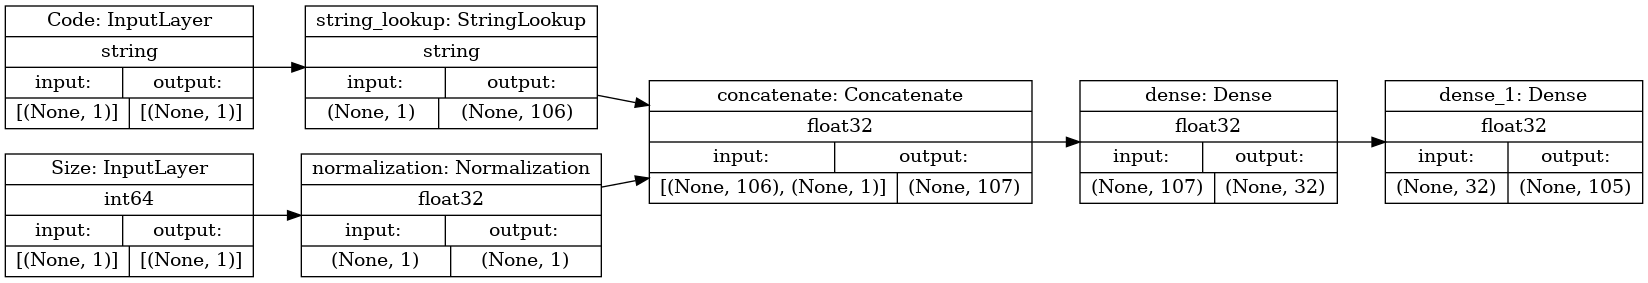

In [10]:
# initialize iban_model
iban_model = build_model(input_dataset, len(iban_dataframe))

# print model
tf.keras.utils.plot_model(iban_model, show_shapes=True, show_dtype=True, rankdir="LR")

# Training and plotting the results

  - After confirming the model topology is according to expectations, the model can be trained.
  - The training history is plot with two variables
    - Error Loss
    - Accuracy
  - Descending curve for error loss is a good signal
  - Raising curve for accuracy is also a good signal

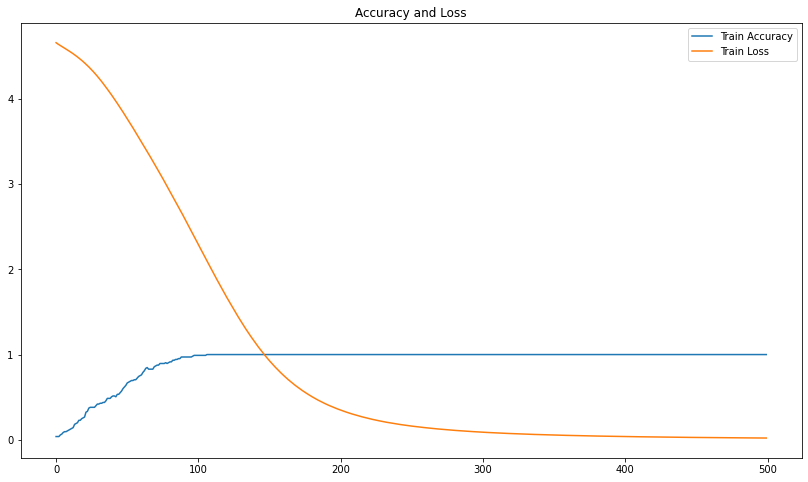

In [11]:
# train model and plot results
training_history = iban_model.fit(input_dataset, epochs=num_epochs, verbose=0)

train_acc = training_history.history["accuracy"]
train_loss = training_history.history["loss"]

epochs_range = range(num_epochs)
plt.figure(figsize=(14, 8))
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.title("Accuracy and Loss")
plt.legend()

# Predictions

  - Now model training process is complete it can be used to make predictions
  - The predict_json utility function is used to return real prediction
  - The validate_iban function uses the prediction to validate and parse a input iban and serve as a simple use case

In [12]:
iban_dataframe.sample(3)

,Code,Size,JSON
22,CY,28,"{""country"":""Cyprus"",""bban_regex"":""[0-9]{8}[A-Z..."
94,ST,25,"{""country"":""Sao Tome and Principe"",""bban_regex..."
42,GT,28,"{""country"":""Guatemala"",""bban_regex"":""[A-Za-z0-..."


In [13]:
print("JSON Result: {}".format(predict_json(iban_model, iban_dataframe, code="LU", size=20)))

JSON Result: {"country":"Luxembourg","bban_regex":"[0-9]{3}[A-Za-z0-9]{13}","check_digit_regex":"[0-9][0-9]","code":"LU","size":20}


In [14]:
example_iban = "BR1800000000141455123924100C2"
print("Is IBAN {} Valid? {}".format(example_iban,validate_iban(iban_model, iban_dataframe, example_iban)))

Is IBAN BR1800000000141455123924100C2 Valid? True


# Conclusion

  - This simple model explores the encoding layers in order to fit to some input tabular data and perform predictions.
  - It is a multi class classification model with top scorer selected as the output prediction
  - Overfitting is not an issue for this specific model, it is a requirement in order to increase accuracy. 
  - The model reached its original goal of designing and implementing an Artificial Neural Network for validating IBAN account numbers.
  - The following resources served as references for this model:
    - [https://www.swift.com/standards/data-standards/iban-international-bank-account-number](https://www.swift.com/standards/data-standards/iban-international-bank-account-number) 
    - [http://toms-cafe.de/iban/iban.html](http://toms-cafe.de/iban/iban.html)
    - [https://github.com/open-ibans/ibans-python](https://github.com/open-ibans/ibans-python)
    - [https://keras.io/examples/structured_data/structured_data_classification_from_scratch/](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)
    - [https://keras.io/guides/preprocessing_layers/](https://keras.io/guides/preprocessing_layers/)




For reporting errors or questions please contact me by [e-mail](mail@bsantanna.me)

Copyright 2022 [Bruno César Brito Sant’Anna](https://www.linkedin.com/in/brnsantanna/)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.